<a href="https://colab.research.google.com/github/czheng11/czheng11.github.io/blob/master/project3_customdatacycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS145: Project 3 | Custom Data Cycle
---

We choose the bigquery-public-data.nhtsa_traffic_fatalities dataset. The dataset captures vital information about car accidents including but not limited to the type of vehicle,  when the crash occurred, the first harmful event, the vehicle body type and more. We choose this dataset because we want to dive deeper into the distribution of car crashes to see if there are more underlying variables that increase the likelihood/correlation of a crash. We hope to create a ML model that is able to predict the chance of crashing and number of fatalities.



## Questions we are exploring

* What variables are good predictors of a crash occurring with more than 1 fatalities?
  * Location?
  * Drunk driving?
  * Day of week?
  * Time of Day?
  * Vehicle type?
  * Age?
* Individualized probability of a specific person, car, etc. crashing (are there implicit functional dependencies we can figure out that are good at determining probability of additional fatalities and the type of incident?)





In [0]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-project-1-218601" 

In [0]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)  # pass in your projectid

In [0]:
# Visualization Libraries
import altair as alt
import matplotlib.pyplot as plt
from vega_datasets import data

# Part 1 | Analysis of Dataset


## Tables





### Overview 

Within the nhtsa_traffic_fatalities dataset there are 40 different tables. Interestingly, each table has a suffix of either _2015 or _2016 denoting the year the events in the table occured in. Essentially, there are then only 20 tables. We decided for this project to use only the tables with the _2016 suffix in order to take into account the most recent data. 

Within all tables there are columns for state_number and consecutive_number. State_number identifies the state in which the crash occured. Consecutive_number is a unique case number that is assigned to each crash.

In general here are each table and the information that the table contains.

* accident_2016 - one record per a crash, contains details on crash characteristics and environmental conditions
* cevent_2016 - one record per event, contains a description of the event or object contacted, vehicles involved, and where the vehicle was impacted
* damage_2016 - one record per damaged area, contains details on the areas on a vehicle that were damaged in the crash
* distract_2016 - at least one record per in-transport motor vehicle, each distraction is a seperate record, contains details on driver distractions
* drimpair_2016 - at least one record for each driver of an in-transport motor vehicle, one record per impairment, contains details on physical impairments of drivers of motor vehicles
* factor_2016 - at least one record per in-transport motor vehicle, each factor is a seperate record, contains details about vehicle circumstances which may have contributed to the crash
* maneuver_2016 - at least one record per in-transport motor vehicle, each maneuver is a seperate record, contains details regarding actions taken by the driver to avoid something/someone in the road
* nmcrash_2016 - at least one record for each person who is not an occupant of a motor vehicle, one record per action, contains details about any contributing circumstances or improper actions of people who are not occupants of motor vehicles
* nmimpair_2016 - at least one record for each person who is not an occupant of a motor vehicle, one record per impairment, contains details about physical impairements of people who are not occupants of motor vehicles
* nmprior_2016 - at least one record for each person who is not an occupant of a motor vehicle, one record per action, contains details about the actions of people who are not occupants of motor vehicles at the time of their involvment in the crash
* parkwork_2016 - one record per parked/working vehicle, contains details about parked or working vehicles involved in FARS (Fatality Analysis Reporting System) crashes
* pbtype_2016 - one record for each pedestrian, bicyclist or person on a personal conveyance, contains details about crashes between motor vehicles and pedestrians, people on personal conveyances and bicyclists.
* person_2016 - one record per person, contains details describing all persons involved in the crash like age, sex, vehicle occupant restraint use, and injury severity
* safetyeq_2016 - at least one record for each person who is not an occupant of a motor vehicle, one record per equipment item, contains details about safety equipment used by people who are not occupants of motor vehicles.
* vehicle_2016 - one record per in-transport motor vehicle, contains details describing the in-transport motor vehicles and the drivers of in-transport motor vehicles who are involved in the crash.
* vevent_2016 - one record for each event for each in-transport motor vehicle, contains details on the sequence of events for each intransport motor vehicle involved in the crash. (Same data elements as Cevent data but also records the sequential event number for each vehicle)
* vindecode_2016 - one record per vehicle, contains details describing a vehicle based on the vehicle's VIN.
* violatn_2016 - at least one record per in-transport motor vehicle, each violation is a seperate record, contains details about violations which were charged to drivers.
* vision_2016 - at least one record per in-transport motor vehicle, each obstruction is a seperate record, contains details about circumstances which may have obscured the driver's vision.
* vsoe_2016 - one record for each event for each in-transport motor vehicle, contains the sequence of events for each intransport motor vehicle involved in the crash. (Simplified Vevent)

### Redundant Data/Tables

There is redundant data. For example, vsoe_2016 is an abridged version of vevent_2016. We can see that both tables have one record for each event for each in-transport motor vehicle and contains details on the sequence of events for each intransport motor vehicle. Furthermore, we can go another layer and see that vevent_2016 has redundant data with cevent_2016 as vevent_2016 has the same data elements but also record the VIN as an identifier for data. 

If we compare vehicle_2016 and accident_2016 we can see many redundant columns such as: timestamp_of_crash, first_harmful_event, first_harmful_event_name, and (day/month/hour/minute)_of_crash, etc. This is interesting as vehicle_2016 contains one record per in-transport motor vehicle and accident_2016 contains one record per crash which may contain multiple in-transport motor vehicles. Therefore, this data could be redundant multiple times. 

Moreover, many tables include the raw timestamp as well as year, month, day, hour, minute columns which is redundant as timestamp tells all this information.

In general we see some redundant data, and we believe the purpose is to make querying easier for the user. So for example, if they want to determine the hour of events they do not need to manually calculate the hour from the timestamp, or if they want information about the first_harmful_event in a specific vehicle now they don't need to join accident_2016 to get the data. 



### Relationships

For our project we narrowed the scope of our exploration to the following tables:

accident_2016, vehicle_2016, violatn_2016, person_2016

Here are the relationships between the tables we will be using. Accident_2016 has one record per crash and vehicle_2016 has one record per in-transport motor vehicle. There can be many vehicle_2016 records per crash or accident_2016 record. There is also a many to one relationship between person_2016 records and both vehicle_2016 records and accident_2016. violatn_2016 has at least one record per vehicle so it has a many to one relationship with vehicle_2016 records. 


### Database Design

There is a column called consecutive_number is a unique case number assigned to each crash. This data element is used to join all the data files together. In a sense, consecutive_number acts like a foreign key to allow us to join tables. In this sense we can see that the data we are looking at could be displayed in one large table, but this would not be ideal. The authors instead decided to split the dataset into tables for specific discrete pieces of information. In this sense the tables are normalized into tables that often have one to many/many to one relationships in order to better model a crash. This is important because a crash can for example have any number of in-transit vehicles. If this data was modeled as columns we would need either one column for each car which would be infeasible to account for n cars where n is sufficiently large. Moreover, even if we ensure that we have a column for max n cars the majority of the records in the columns will be null. Yes there are keys in the functional dependency sense. For example, in the accident_2016 table we can clearly see that the key is consecutive_number. And, for vehicle_2016, violatn_2016 and person_2016 there are also keys.  Within the four tables that we choose to dive deeper into we do not see an OKV style breakdown of data. For example, within the accident_2016 table we have columns like number_of_vehicle_forms_submitted_all, number_of_parked_working_vehicles, number_of_persons_not_in_motor_vehicles_in_transport_mvit, etc. which would probably be more efficiently stores in the OKV sense. This way it would also be easier to tag on another piece of data that for example looks at number_of_[NEW DATA]. This is a tradeoff that we believe the author of the dataset should have made to better optimize their data.

# Part 2 | Visualizing Data

# Figure 1. Sum of fatalities distributed over states during 2016
In order to better understand the relationship between states in which the crashes occurred and number of fatalities, to start off let's first look at a brief overview of the total number of fatalities per state.

In [0]:
%%bigquery --project $project_id fatalities_per_state

SELECT 
  SUM(number_of_fatalities) AS total_fatalities,
  state_name,
  state_number
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`
GROUP BY
  state_name, state_number
HAVING
  state_name <> "District of Columbia"
ORDER BY 
  state_name

,total_fatalities,state_name,state_number
0,1083,Alabama,1
1,84,Alaska,2
2,952,Arizona,4
3,561,Arkansas,5
4,3837,California,6
5,608,Colorado,8
6,304,Connecticut,9
7,119,Delaware,10
8,3176,Florida,12
9,1556,Georgia,13


In [0]:
states = alt.topo_feature(data.us_10m.url, 'states')

variable_list = ['total_fatalities']

alt.Chart(states).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(fatalities_per_state, 'state_number', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)

RepeatChart({
  repeat: Repeat({
    row: ['total_fatalities']
  }),
  resolve: Resolve({
    scale: ScaleResolveMap({
      color: 'independent'
    })
  }),
  spec: Chart({
    data: UrlData({
      format: TopoDataFormat({
        feature: 'states',
        type: 'topojson'
      }),
      url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
    }),
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: RepeatRef({
          repeat: 'row'
        }),
        type: 'quantitative'
      })
    }),
    height: 300,
    mark: 'geoshape',
    projection: Projection({
      type: 'albersUsa'
    }),
    transform: [LookupTransform({
      from: LookupData({
        data:     total_fatalities      state_name  state_number
        0               1083         Alabama             1
        1                 84          Alaska             2
        2                952         Arizona             4
        3                561        Arkansas             5
        4               3837      California             6
        5                608        Colorado             8
        6                304     Connecticut             9
        7                119        Delaware            10
        8               3176         Florida            12
        9               1556         Georgia            13
        10               120          Hawaii            15
        11               253           Idaho            16
        12              1078        Illinois            17
        13               829         Indiana            18
        14               402            Iowa            19
        15               429          Kansas            20
        16               834        Kentucky            21
        17               757       Louisiana            22
        18               160           Maine            23
        19               522        Maryland            24
        20               387   Massachusetts            25
        21              1065        Michigan            26
        22               392       Minnesota            27
        23               687     Mississippi            28
        24               947        Missouri            29
        25               190         Montana            30
        26               218        Nebraska            31
        27               329          Nevada            32
        28               136   New Hampshire            33
        29               602      New Jersey            34
        30               405      New Mexico            35
        31              1041        New York            36
        32              1450  North Carolina            37
        33               113    North Dakota            38
        34              1132            Ohio            39
        35               687        Oklahoma            40
        36               498          Oregon            41
        37              1188    Pennsylvania            42
        38                51    Rhode Island            44
        39              1020  South Carolina            45
        40               116    South Dakota            46
        41              1037       Tennessee            47
        42              3797           Texas            48
        43               281            Utah            49
        44                62         Vermont            50
        45               760        Virginia            51
        46               536      Washington            53
        47               269   West Virginia            54
        48               607       Wisconsin            55
        49               112         Wyoming            56,
        fields: ['total_fatalities'],
        key: 'state_number'
      }),
      lookup: 'id'
    })],
    width: 500
  })
})

Here we can see that the most number of fatalities occur in California and Texas. However, this is most likely because these states have also the highest population. In order to address this concer, let us normalize by the population in each state in the next query.

# Figure 2. Sum of fatalities normalized by the population per state

In [0]:
%%bigquery --project $project_id fatalities_per_state_normalized

SELECT
  accidents.state_name AS state,
  accidents.state_number,
  pops.state_pop/3 AS population,
  SUM(number_of_fatalities)/(pops.state_pop/3) AS total_fatalities_normalized
FROM
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accidents,
  (
    SELECT
      SUM(census.population) AS state_pop,
      zip.state_name AS state
    FROM
      `bigquery-public-data.census_bureau_usa.population_by_zip_2010` census, `bigquery-public-data.utility_us.zipcode_area` zip
    WHERE
      census.zipcode=zip.zipcode
    GROUP BY
      state 
  ) pops
WHERE
  pops.state=accidents.state_name
GROUP BY
  accidents.state_name,
  accidents.state_number,
  pops.state_pop


,state,state_number,population,total_fatalities_normalized
0,Minnesota,27,5301349.0,0.000074
1,South Carolina,45,4625364.0,0.000221
2,Pennsylvania,42,12702375.0,0.000094
3,Ohio,39,11536514.0,0.000098
4,New Hampshire,33,1316573.0,0.000103
5,New York,36,19378077.0,0.000054
6,Louisiana,22,4532830.0,0.000167
7,Washington,53,6413354.0,0.000084
8,Idaho,16,1567526.0,0.000161
9,North Carolina,37,9535477.0,0.000152


In [0]:
states = alt.topo_feature(data.us_10m.url, 'states')

variable_list = ['total_fatalities_normalized']

alt.Chart(states).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(fatalities_per_state_normalized, 'state_number', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)

RepeatChart({
  repeat: Repeat({
    row: ['total_fatalities_normalized']
  }),
  resolve: Resolve({
    scale: ScaleResolveMap({
      color: 'independent'
    })
  }),
  spec: Chart({
    data: UrlData({
      format: TopoDataFormat({
        feature: 'states',
        type: 'topojson'
      }),
      url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
    }),
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: RepeatRef({
          repeat: 'row'
        }),
        type: 'quantitative'
      })
    }),
    height: 300,
    mark: 'geoshape',
    projection: Projection({
      type: 'albersUsa'
    }),
    transform: [LookupTransform({
      from: LookupData({
        data:                    state  state_number  population  \
        0              Minnesota            27   5301349.0   
        1         South Carolina            45   4625364.0   
        2           Pennsylvania            42  12702375.0   
        3                   Ohio            39  11536514.0   
        4          New Hampshire            33   1316573.0   
        5               New York            36  19378077.0   
        6              Louisiana            22   4532830.0   
        7             Washington            53   6413354.0   
        8                  Idaho            16   1567526.0   
        9         North Carolina            37   9535477.0   
        10               Georgia            13   9426838.0   
        11           Connecticut             9   3574097.0   
        12               Florida            12  18801226.0   
        13                Alaska             2    709930.0   
        14         West Virginia            54   1852774.0   
        15         Massachusetts            25   6547612.0   
        16               Alabama             1   4779588.0   
        17             Tennessee            47   6334365.0   
        18               Indiana            18   6483792.0   
        19                Oregon            41   3830235.0   
        20              Delaware            10    897925.0   
        21              Arkansas             5   2911179.0   
        22                  Utah            49   2761810.0   
        23              Michigan            26   9883612.0   
        24               Arizona             4   6375883.0   
        25            New Mexico            35   2053681.0   
        26              Missouri            29   5987135.0   
        27             Wisconsin            55   5687012.0   
        28          South Dakota            46    811543.0   
        29                Kansas            20   2850628.0   
        30                Hawaii            15   1360301.0   
        31          Rhode Island            44   1052581.0   
        32               Vermont            50    625741.0   
        33                 Texas            48  25144771.0   
        34          North Dakota            38    671781.0   
        35              Kentucky            21   4325711.0   
        36               Montana            30    988345.0   
        37              Virginia            51   8001239.0   
        38               Wyoming            56    561118.0   
        39                Nevada            32   2699808.0   
        40              Illinois            17  12830581.0   
        41  District of Columbia            11    593496.0   
        42              Nebraska            31   1826766.0   
        43            New Jersey            34   8791894.0   
        44              Maryland            24   5773561.0   
        45                  Iowa            19   3043678.0   
        46              Oklahoma            40   3749950.0   
        47                 Maine            23   1328255.0   
        48            California             6  37249542.0   
        49              Colorado             8   5029374.0   
        50           Mississippi            28   3066741.0   
        
            total_fatalities_normalized  
        0         

Now that we have normalized the total number of fatalities by the population of the state we can see that California and Texas do not have the highest normalized fatality rate. Rather states like South Carolina, Alabama, and Mississippi have higher rates. Furthermore, the trend seems like more southern and midwestern states have higher number of fatalities in a crash.

# Figure 3. Sum of number of drunk drivers distributed over states during 2016
Next factor we would like to explore is the factor of the number of drunk drivers involved per crash. To better understand this factor, let's look at the number of drunk drivers per state.

In [0]:
%%bigquery --project $project_id drunk_per_state

SELECT 
  SUM(number_of_drunk_drivers) AS total_drunk,
  state_name,
  state_number
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`
GROUP BY
  state_name, state_number
HAVING
  state_name <> "District of Columbia"
ORDER BY 
  state_name

,total_drunk,state_name,state_number
0,282,Alabama,1
1,36,Alaska,2
2,210,Arizona,4
3,123,Arkansas,5
4,1052,California,6
5,194,Colorado,8
6,91,Connecticut,9
7,39,Delaware,10
8,665,Florida,12
9,315,Georgia,13


In [0]:
states = alt.topo_feature(data.us_10m.url, 'states')

variable_list = ['total_drunk']

alt.Chart(states).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(drunk_per_state, 'state_number', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)

RepeatChart({
  repeat: Repeat({
    row: ['total_drunk']
  }),
  resolve: Resolve({
    scale: ScaleResolveMap({
      color: 'independent'
    })
  }),
  spec: Chart({
    data: UrlData({
      format: TopoDataFormat({
        feature: 'states',
        type: 'topojson'
      }),
      url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
    }),
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: RepeatRef({
          repeat: 'row'
        }),
        type: 'quantitative'
      })
    }),
    height: 300,
    mark: 'geoshape',
    projection: Projection({
      type: 'albersUsa'
    }),
    transform: [LookupTransform({
      from: LookupData({
        data:     total_drunk      state_name  state_number
        0           282         Alabama             1
        1            36          Alaska             2
        2           210         Arizona             4
        3           123        Arkansas             5
        4          1052      California             6
        5           194        Colorado             8
        6            91     Connecticut             9
        7            39        Delaware            10
        8           665         Florida            12
        9           315         Georgia            13
        10           33          Hawaii            15
        11           65           Idaho            16
        12          315        Illinois            17
        13          154         Indiana            18
        14           96            Iowa            19
        15           85          Kansas            20
        16          193        Kentucky            21
        17          229       Louisiana            22
        18           57           Maine            23
        19          125        Maryland            24
        20          107   Massachusetts            25
        21          258        Michigan            26
        22           98       Minnesota            27
        23          107     Mississippi            28
        24          249        Missouri            29
        25           82         Montana            30
        26           78        Nebraska            31
        27           97          Nevada            32
        28           39   New Hampshire            33
        29          135      New Jersey            34
        30          108      New Mexico            35
        31          178        New York            36
        32          399  North Carolina            37
        33           50    North Dakota            38
        34          365            Ohio            39
        35          178        Oklahoma            40
        36          130          Oregon            41
        37          278    Pennsylvania            42
        38           18    Rhode Island            44
        39          324  South Carolina            45
        40           44    South Dakota            46
        41          235       Tennessee            47
        42          918           Texas            48
        43           52            Utah            49
        44           28         Vermont            50
        45          217        Virginia            51
        46          161      Washington            53
        47           69   West Virginia            54
        48          182       Wisconsin            55
        49           30         Wyoming            56,
        fields: ['total_drunk'],
        key: 'state_number'
      }),
      lookup: 'id'
    })],
    width: 500
  })
})

Again, let us look at the total number drunk drivers who got into accidents. This map reflects the previous map because of the population of each state. In the next query let us normalize by the population in each state.

# Figure 4. Number of Drunk Drivers distributed over states normalized
With the same reasoning as above, let's normalize the number of drunk drivers as well.

In [0]:
%%bigquery --project $project_id drunk_per_state_normalized

SELECT
  accidents.state_name AS state,
  accidents.state_number,
  pops.state_pop/3 AS population,
  SUM(number_of_drunk_drivers)/(pops.state_pop/3) AS total_drunk_normalized
FROM
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accidents,
  (
    SELECT
      SUM(census.population) AS state_pop,
      zip.state_name AS state
    FROM
      `bigquery-public-data.census_bureau_usa.population_by_zip_2010` census, `bigquery-public-data.utility_us.zipcode_area` zip
    WHERE
      census.zipcode=zip.zipcode
    GROUP BY
      state 
  ) pops
WHERE
  pops.state=accidents.state_name
GROUP BY
  accidents.state_name,
  accidents.state_number,
  pops.state_pop


,state,state_number,population,total_drunk_normalized
0,Minnesota,27,5301349.0,0.000018
1,South Carolina,45,4625364.0,0.000070
2,Pennsylvania,42,12702375.0,0.000022
3,Ohio,39,11536514.0,0.000032
4,New Hampshire,33,1316573.0,0.000030
5,New York,36,19378077.0,0.000009
6,Louisiana,22,4532830.0,0.000051
7,Washington,53,6413354.0,0.000025
8,Idaho,16,1567526.0,0.000041
9,North Carolina,37,9535477.0,0.000042


In [0]:
states = alt.topo_feature(data.us_10m.url, 'states')

variable_list = ['total_drunk_normalized']

alt.Chart(states).mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative')
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(drunk_per_state_normalized, 'state_number', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)

RepeatChart({
  repeat: Repeat({
    row: ['total_drunk_normalized']
  }),
  resolve: Resolve({
    scale: ScaleResolveMap({
      color: 'independent'
    })
  }),
  spec: Chart({
    data: UrlData({
      format: TopoDataFormat({
        feature: 'states',
        type: 'topojson'
      }),
      url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
    }),
    encoding: EncodingWithFacet({
      color: Color({
        shorthand: RepeatRef({
          repeat: 'row'
        }),
        type: 'quantitative'
      })
    }),
    height: 300,
    mark: 'geoshape',
    projection: Projection({
      type: 'albersUsa'
    }),
    transform: [LookupTransform({
      from: LookupData({
        data:                    state  state_number  population  total_drunk_normalized
        0              Minnesota            27   5301349.0                0.000018
        1         South Carolina            45   4625364.0                0.000070
        2           Pennsylvania            42  12702375.0                0.000022
        3                   Ohio            39  11536514.0                0.000032
        4          New Hampshire            33   1316573.0                0.000030
        5               New York            36  19378077.0                0.000009
        6              Louisiana            22   4532830.0                0.000051
        7             Washington            53   6413354.0                0.000025
        8                  Idaho            16   1567526.0                0.000041
        9         North Carolina            37   9535477.0                0.000042
        10               Georgia            13   9426838.0                0.000033
        11           Connecticut             9   3574097.0                0.000025
        12               Florida            12  18801226.0                0.000035
        13                Alaska             2    709930.0                0.000051
        14         West Virginia            54   1852774.0                0.000037
        15         Massachusetts            25   6547612.0                0.000016
        16               Alabama             1   4779588.0                0.000059
        17             Tennessee            47   6334365.0                0.000037
        18               Indiana            18   6483792.0                0.000024
        19                Oregon            41   3830235.0                0.000034
        20              Delaware            10    897925.0                0.000043
        21              Arkansas             5   2911179.0                0.000042
        22                  Utah            49   2761810.0                0.000019
        23              Michigan            26   9883612.0                0.000026
        24               Arizona             4   6375883.0                0.000033
        25            New Mexico            35   2053681.0                0.000053
        26              Missouri            29   5987135.0                0.000042
        27             Wisconsin            55   5687012.0                0.000032
        28          South Dakota            46    811543.0                0.000054
        29                Kansas            20   2850628.0                0.000030
        30                Hawaii            15   1360301.0                0.000024
        31          Rhode Island            44   1052581.0                0.000017
        32               Vermont            50    625741.0                0.000045
        33                 Texas            48  25144771.0                0.000037
        34          North Dakota            38    671781.0                0.000074
        35              Kentucky            21   4325711.0                0.000045
        36               Montana            30    988345.0                0.000083
        37              Virginia            51   8001239.0                0.000027
        38               Wyoming            56    561118.0   

After normalized we can see that this chart has similarities with the map of normalized number of fatalities. South Carolina, Montana, and North Dakota have the highest normalized number of drunk drivers and they all have relatively high normalized numbers of fatalities as well. This is interesting since we can see that there may be a correlation between fatalities and drunk drivers where midwestern and southern states seem to be more likely to have higher fatalities and drunk drivers. Let us look deeper into the effect of the number of drunk drivers on the average fatality in the next query.

# Figure 5. Effect of the number of drunk drivers on the average fatalities
We hypothesized that the increased number of drunk drivers involved in a crash would increase the average number of fatalities, which indicates increased occurrence of more than 1 fatality per crash. So, next we explored the effect of the number of drunk drivers on fatalities.

In [0]:
%%bigquery --project $project_id num_drunk_on_fatalities

SELECT 
  number_of_drunk_drivers, 
  AVG(number_of_fatalities) avg_num_fatalities_per_crash, 
  COUNT(consecutive_number) number_of_crashes
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`
GROUP BY 
  number_of_drunk_drivers

,number_of_drunk_drivers,avg_num_fatalities_per_crash,number_of_crashes
0,0,1.077706,25442
1,1,1.110164,9032
2,2,1.306273,271
3,3,2.000000,3


In [0]:
alt.Chart(num_drunk_on_fatalities).mark_bar().encode(
    x='number_of_drunk_drivers:N',
    y='avg_num_fatalities_per_crash'
)

Chart({
  data:    number_of_drunk_drivers  avg_num_fatalities_per_crash  number_of_crashes
  0                        0                      1.077706              25442
  1                        1                      1.110164               9032
  2                        2                      1.306273                271
  3                        3                      2.000000                  3,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'number_of_drunk_drivers:N'
    }),
    y: Y({
      shorthand: 'avg_num_fatalities_per_crash'
    })
  }),
  mark: 'bar'
})

This is interesting. We can see that if there is one drunk driver involved in an accident the average number of fatalities increases by around 0.03 which is trivial. However, if there are two drunk drivers in an accident than the number of fatalities increased by 0.23! We see that for 3 drunk drivers involved, there's a significant increase in average number of fatalities per crash but since there may be a small number of crashes of this type in the dataset, we may not be able to infer too much. From these findings, we think that the presence of drunk drivers in a crash may be a small predictor of additional fatalities (>1).

# Figure 6. Does the day of the week affect the number of fatalities?
We hypothesized that certain days would have increased average number of fatalities. Let's explore the effect of day of week on average number of fatalities per crash now!

In [0]:
%%bigquery --project $project_id week_on_fatalities

SELECT 
  day_of_week, 
  AVG(number_of_fatalities) avg_num_fatalities_per_crash, 
  AVG(number_of_drunk_drivers) avg_num_drunks_per_crash, 
  COUNT(consecutive_number) number_of_crashes
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`
GROUP BY 
  day_of_week
ORDER BY 
  day_of_week

,day_of_week,avg_num_fatalities_per_crash,avg_num_drunks_per_crash,number_of_crashes
0,1,1.097702,0.389314,5353
1,2,1.084858,0.217985,4537
2,3,1.078662,0.191003,4157
3,4,1.069610,0.208606,4439
4,5,1.072673,0.223119,4706
5,6,1.087456,0.261256,5397
6,7,1.113655,0.378308,6159


In [0]:
alt.Chart(week_on_fatalities).mark_bar().encode(
    alt.X('day_of_week:N'),
    alt.Y('avg_num_fatalities_per_crash:Q',
          scale=alt.Scale(domain=(0, 1.12)))
)


Chart({
  data:    day_of_week  avg_num_fatalities_per_crash  avg_num_drunks_per_crash  \
  0            1                      1.097702                  0.389314   
  1            2                      1.084858                  0.217985   
  2            3                      1.078662                  0.191003   
  3            4                      1.069610                  0.208606   
  4            5                      1.072673                  0.223119   
  5            6                      1.087456                  0.261256   
  6            7                      1.113655                  0.378308   
  
     number_of_crashes  
  0               5353  
  1               4537  
  2               4157  
  3               4439  
  4               4706  
  5               5397  
  6               6159  ,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'day_of_week:N'
    }),
    y: Y({
      scale: Scale({
        domain: (0, 1.12)
      }),
      shorthand: 'avg_num_fatalities_per_crash:Q'
    })
  }),
  mark: 'bar'
})

In [0]:
alt.Chart(week_on_fatalities).mark_bar().encode(
    alt.X('day_of_week:N'),
    alt.Y('avg_num_drunks_per_crash:Q')
)


Chart({
  data:    day_of_week  avg_num_fatalities_per_crash  avg_num_drunks_per_crash  \
  0            1                      1.097702                  0.389314   
  1            2                      1.084858                  0.217985   
  2            3                      1.078662                  0.191003   
  3            4                      1.069610                  0.208606   
  4            5                      1.072673                  0.223119   
  5            6                      1.087456                  0.261256   
  6            7                      1.113655                  0.378308   
  
     number_of_crashes  
  0               5353  
  1               4537  
  2               4157  
  3               4439  
  4               4706  
  5               5397  
  6               6159  ,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'day_of_week:N'
    }),
    y: Y({
      shorthand: 'avg_num_drunks_per_crash:Q'
    })
  }),
  mark: 'bar'
})

We can see that there are higher average number of fatalities per crash over the weekend, Saturday(7) and Sunday (1). And, the average number of drunk drivers per crash during weekend is almost twice than on a weekday! This indicates that day of week when crashes occur may be a good predictor of whether a crash occurs with more than 1 fatality. Can we look into more granular detail on time of day?

# Figure 7. What hour do fatalities happen?
We wanted to investigate whether hour of day when the crash occurred affected the average number of fatalities. We thought this would be an interesting next feature to investigate since we thought that certain hours, such as really late or really early in the day, could result in riskier driving/pedestrian behavior which would result in higher number of fatalities that occur in a crash. 

In [0]:
%%bigquery --project $project_id hour_on_fatalities

SELECT 
  hour_of_crash, 
  AVG(number_of_fatalities) avg_num_fatalities_per_crash, 
  AVG(number_of_drunk_drivers) avg_num_drunks_per_crash, 
  COUNT(consecutive_number) number_of_crashes
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`
GROUP BY 
  hour_of_crash
HAVING
  hour_of_crash <> 99
ORDER BY 
  hour_of_crash

,hour_of_crash,avg_num_fatalities_per_crash,avg_num_drunks_per_crash,number_of_crashes
0,0,1.099634,0.526007,1365
1,1,1.110764,0.572543,1282
2,2,1.105417,0.637628,1366
3,3,1.105416,0.519342,1034
4,4,1.103286,0.415493,852
5,5,1.077720,0.231434,1158
6,6,1.069659,0.146285,1292
7,7,1.086012,0.128584,1151
8,8,1.079218,0.103909,972
9,9,1.082164,0.074148,998


In [0]:
alt.Chart(hour_on_fatalities).mark_bar().encode(
    alt.X('hour_of_crash:N'),
    alt.Y('avg_num_fatalities_per_crash:Q')
)


Chart({
  data:     hour_of_crash  avg_num_fatalities_per_crash  avg_num_drunks_per_crash  \
  0               0                      1.099634                  0.526007   
  1               1                      1.110764                  0.572543   
  2               2                      1.105417                  0.637628   
  3               3                      1.105416                  0.519342   
  4               4                      1.103286                  0.415493   
  5               5                      1.077720                  0.231434   
  6               6                      1.069659                  0.146285   
  7               7                      1.086012                  0.128584   
  8               8                      1.079218                  0.103909   
  9               9                      1.082164                  0.074148   
  10             10                      1.075269                  0.094819   
  11             11                      1.080386                  0.087621   
  12             12                      1.096750                  0.088435   
  13             13                      1.078187                  0.105782   
  14             14                      1.091255                  0.129278   
  15             15                      1.113532                  0.165138   
  16             16                      1.096756                  0.200110   
  17             17                      1.080787                  0.229415   
  18             18                      1.082294                  0.264838   
  19             19                      1.070239                  0.305931   
  20             20                      1.077795                  0.308604   
  21             21                      1.087459                  0.359186   
  22             22                      1.093317                  0.392535   
  23             23                      1.082999                  0.453146   
  
      number_of_crashes  
  0                1365  
  1                1282  
  2                1366  
  3                1034  
  4                 852  
  5                1158  
  6                1292  
  7                1151  
  8                 972  
  9                 998  
  10               1023  
  11               1244  
  12               1323  
  13               1522  
  14               1578  
  15               1744  
  16               1819  
  17               1931  
  18               2005  
  19               1922  
  20               1941  
  21               1818  
  22               1661  
  23               1494  ,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'hour_of_crash:N'
    }),
    y: Y({
      shorthand: 'avg_num_fatalities_per_crash:Q'
    })
  }),
  mark: 'bar'
})

In [0]:
alt.Chart(hour_on_fatalities).mark_bar().encode(
    alt.X('hour_of_crash:N'),
    alt.Y('avg_num_drunks_per_crash:Q')
)


Chart({
  data:     hour_of_crash  avg_num_fatalities_per_crash  avg_num_drunks_per_crash  \
  0               0                      1.099634                  0.526007   
  1               1                      1.110764                  0.572543   
  2               2                      1.105417                  0.637628   
  3               3                      1.105416                  0.519342   
  4               4                      1.103286                  0.415493   
  5               5                      1.077720                  0.231434   
  6               6                      1.069659                  0.146285   
  7               7                      1.086012                  0.128584   
  8               8                      1.079218                  0.103909   
  9               9                      1.082164                  0.074148   
  10             10                      1.075269                  0.094819   
  11             11                      1.080386                  0.087621   
  12             12                      1.096750                  0.088435   
  13             13                      1.078187                  0.105782   
  14             14                      1.091255                  0.129278   
  15             15                      1.113532                  0.165138   
  16             16                      1.096756                  0.200110   
  17             17                      1.080787                  0.229415   
  18             18                      1.082294                  0.264838   
  19             19                      1.070239                  0.305931   
  20             20                      1.077795                  0.308604   
  21             21                      1.087459                  0.359186   
  22             22                      1.093317                  0.392535   
  23             23                      1.082999                  0.453146   
  
      number_of_crashes  
  0                1365  
  1                1282  
  2                1366  
  3                1034  
  4                 852  
  5                1158  
  6                1292  
  7                1151  
  8                 972  
  9                 998  
  10               1023  
  11               1244  
  12               1323  
  13               1522  
  14               1578  
  15               1744  
  16               1819  
  17               1931  
  18               2005  
  19               1922  
  20               1941  
  21               1818  
  22               1661  
  23               1494  ,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'hour_of_crash:N'
    }),
    y: Y({
      shorthand: 'avg_num_drunks_per_crash:Q'
    })
  }),
  mark: 'bar'
})

This is really interesting because we can see the hour of the crash doesn't really have an effect on the average number of fatalities although it can predict the average number of drunk drivers per crash! Not many people are day drinking! Let's now start to look at the vehicle body type and its effect on the number of fatalities.

# Figure 8. Does vehicle body type affect the average number of fatalities?
We were interested to see if the type of vehicle/body type influenced fatalities in crash. So let's explore if the body type is a predictor of additional fatalities (increased average number of fatalities).

In [0]:
%%bigquery --project $project_id body_type_on_fatalities

SELECT 
  body_type_name, 
  AVG(number_of_fatalities) avg_num_fatalities_per_crash, 
  COUNT(DISTINCT v.consecutive_number) number_of_crashes
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` v, 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a
WHERE 
  v.consecutive_number = a.consecutive_number 
GROUP BY 
  body_type_name
ORDER BY 
  avg_num_fatalities_per_crash DESC
LIMIT 20

,body_type_name,avg_num_fatalities_per_crash,number_of_crashes
0,Other Bus Type,2.421053,19
1,"Cross-Country/Intercity Bus (i.e., Greyhound)",1.647059,17
2,Medium/Heavy Truck-Based Motorhome,1.291667,24
3,"Camper or Motorhome, Unknown Truck Type",1.235294,17
4,Unknown Medium/Heavy Truck Type,1.195122,41
5,Step Van or Walk-In Van,1.181818,22
6,School Bus,1.181818,87
7,"Van-Based Bus GVWR > 10,000 lbs. (Since 2011)",1.166667,6
8,Large Van – Includes Van-Based Buses,1.158462,640
9,Minivan,1.150831,1646


In [0]:
alt.Chart(body_type_on_fatalities).mark_bar().encode(
    alt.X('body_type_name:N'),
    alt.Y('avg_num_fatalities_per_crash:Q')
)

Chart({
  data:                                        body_type_name  \
  0                                      Other Bus Type   
  1       Cross-Country/Intercity Bus (i.e., Greyhound)   
  2                  Medium/Heavy Truck-Based Motorhome   
  3             Camper or Motorhome, Unknown Truck Type   
  4                     Unknown Medium/Heavy Truck Type   
  5                             Step Van or Walk-In Van   
  6                                          School Bus   
  7       Van-Based Bus GVWR > 10,000 lbs. (Since 2011)   
  8                Large Van – Includes Van-Based Buses   
  9                                             Minivan   
  10                            3-Door/2-Door Hatchback   
  11  Truck/Tractor (Cab Only, or with Any Number of...   
  12  Single Unit Straight Truck or Cab-Chassis (GVW...   
  13                              Utility Station Wagon   
  14      Station Wagon (Excluding Van and Truck-Based)   
  15  Large Utility (ANSI D-16 Utility Vehicle Categ...   
  16                         2-Door Sedan/Hardtop/Coupe   
  17                             Golf Cart (Since 2012)   
  18                               4-Door Sedan/Hardtop   
  19              Convertible (Excludes Sunroof, T-Bar)   
  
      avg_num_fatalities_per_crash  number_of_crashes  
  0                       2.421053                 19  
  1                       1.647059                 17  
  2                       1.291667                 24  
  3                       1.235294                 17  
  4                       1.195122                 41  
  5                       1.181818                 22  
  6                       1.181818                 87  
  7                       1.166667                  6  
  8                       1.158462                640  
  9                       1.150831               1646  
  10                      1.150082                613  
  11                      1.148344               2608  
  12                      1.141129                246  
  13                      1.133094                277  
  14                      1.132462               1720  
  15                      1.131116               2067  
  16                      1.128081               2232  
  17                      1.125000                 31  
  18                      1.121640              13216  
  19                      1.121037                346  ,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'body_type_name:N'
    }),
    y: Y({
      shorthand: 'avg_num_fatalities_per_crash:Q'
    })
  }),
  mark: 'bar'
})

This finding is to be expected. We can see that on average the most fatalities occur in vehicles that sit more people i.e. the cross-country/other bus. The first car that comes in is the hatchback in 10th place. Coupes are two places above Sedans as well.

# Figure 9. Age of driver on fatalities?
What age of the driver resulted in the highest average number of fatalites? Younger drivers could potentially be more inexperienced,  and older drivers could suffer from poor vision or other ailments, resulting in crashes with more fatalities. We wondered whether such trends could be observed in this data.

In [0]:
%%bigquery --project $project_id age_on_fatalities

SELECT 
  b.age, 
  AVG(number_of_fatalities) AS avg_fatalities
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a, 
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b
WHERE
  b.person_type_name = 'Driver of a Motor Vehicle In-Transport' AND a.consecutive_number = b.consecutive_number
GROUP BY 
  b.age
ORDER BY 
  avg_fatalities DESC
LIMIT
  85

,age,avg_fatalities
0,12,1.222222
1,36,1.150922
2,32,1.149254
3,15,1.147059
4,81,1.144231
5,97,1.142857
6,39,1.142675
7,27,1.142518
8,77,1.141732
9,21,1.140976


In [0]:
alt.Chart(age_on_fatalities).mark_bar().encode(
    alt.X('age:N'),
    alt.Y('avg_fatalities:Q',
         scale=alt.Scale(domain=(0.8, 1.2)))
)

Chart({
  data:     age  avg_fatalities
  0    12        1.222222
  1    36        1.150922
  2    32        1.149254
  3    15        1.147059
  4    81        1.144231
  5    97        1.142857
  6    39        1.142675
  7    27        1.142518
  8    77        1.141732
  9    21        1.140976
  10   42        1.135377
  11   73        1.134375
  12   50        1.132999
  13   33        1.132397
  14   31        1.131731
  15   26        1.131148
  16   59        1.130070
  17   43        1.130051
  18   22        1.129927
  19   37        1.128419
  20   25        1.128125
  21   41        1.125471
  22   76        1.125000
  23   95        1.125000
  24   87        1.123894
  25   28        1.123264
  26   30        1.122772
  27   80        1.122727
  28   17        1.122159
  29   86        1.120000
  ..  ...             ...
  55   38        1.098750
  56   79        1.098592
  57   16        1.098558
  58   45        1.097990
  59   52        1.097614
  60   19        1.096745
  61   71        1.095238
  62   40        1.094578
  63   57        1.092517
  64   55        1.092182
  65   75        1.091255
  66   54        1.091026
  67   83        1.088757
  68   61        1.086495
  69   72        1.084270
  70   64        1.083916
  71   84        1.082353
  72   53        1.081928
  73   90        1.080000
  74   60        1.071839
  75   74        1.071661
  76   78        1.070423
  77   65        1.070370
  78   91        1.058824
  79   14        1.058824
  80   92        1.050000
  81   89        1.045872
  82  998        1.043478
  83   93        1.030303
  84  999        1.021947
  
  [85 rows x 2 columns],
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'age:N'
    }),
    y: Y({
      scale: Scale({
        domain: (0.8, 1.2)
      }),
      shorthand: 'avg_fatalities:Q'
    })
  }),
  mark: 'bar'
})

We can see age is not a good predictor of the likelihood of a crash. Interestingly enough, the youngest driver involved in a crash was 12 in 2016!

# Figure 10. Distribution of Fatalities 
In order to get a good higher-level overview prior to building the machine learning model, let's get a quick sense of the distribution of fatalities.

In [0]:
%%bigquery --project $project_id distribution_on_fatalities

SELECT 
  number_of_fatalities,
  COUNT(consecutive_number) as number_of_accidents
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`
GROUP BY
  number_of_fatalities

,number_of_fatalities,number_of_accidents
0,1,32280
1,2,2040
2,3,317
3,5,19
4,6,9
5,4,81
6,13,1
7,9,1


In [0]:
alt.Chart(distribution_on_fatalities).mark_bar().encode(
    alt.X('number_of_fatalities:N'),
    alt.Y('number_of_accidents:Q')
)

Chart({
  data:    number_of_fatalities  number_of_accidents
  0                     1                32280
  1                     2                 2040
  2                     3                  317
  3                     5                   19
  4                     6                    9
  5                     4                   81
  6                    13                    1
  7                     9                    1,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'number_of_fatalities:N'
    }),
    y: Y({
      shorthand: 'number_of_accidents:Q'
    })
  }),
  mark: 'bar'
})

In [0]:
%%bigquery --project $project_id total_accidents

SELECT 
  COUNT(DISTINCT consecutive_number) as number_of_accidents
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016`

,number_of_accidents
0,34748


In [0]:
%%bigquery --project $project_id injury

SELECT 
  injury_severity_name,
  injury_severity,
  COUNT(consecutive_number) as consecutive_number
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016`
GROUP BY
  injury_severity, injury_severity_name	
ORDER BY 
  injury_severity

,injury_severity_name,injury_severity,consecutive_number
0,No Apparent Injury (O),0,13600
1,Possible Injury (C),1,4802
2,Suspected Minor Injury (B),2,6558
3,Suspected Serious Injury (A),3,6029
4,Fatal Injury (K),4,34748
5,"Injured, Severity Unknown (U) (Since 1978)",5,164
6,Died Prior to Crash,6,3
7,Unknown,9,1216


In [0]:
%%bigquery --project $project_id distribution_people_per_accident

SELECT
  number_of_people,
  COUNT(DISTINCT case_id) as number_of_accidents
FROM
(
  SELECT 
    accident.consecutive_number as case_id,
    COUNT(DISTINCT person.person_number) as number_of_people
  FROM 
    `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
  WHERE
    person.consecutive_number = accident.consecutive_number
  GROUP BY  
    accident.consecutive_number
)
GROUP BY 
  number_of_people
ORDER BY 
  number_of_people LIMIT 10

,number_of_people,number_of_accidents
0,1,20900
1,2,8580
2,3,2826
3,4,1428
4,5,587
5,6,219
6,7,90
7,8,46
8,9,22
9,10,10


In [0]:
alt.Chart(distribution_people_per_accident).mark_bar().encode(
    alt.X('number_of_people:N'),
    alt.Y('number_of_accidents:Q')
)

Chart({
  data:    number_of_people  number_of_accidents
  0                 1                20900
  1                 2                 8580
  2                 3                 2826
  3                 4                 1428
  4                 5                  587
  5                 6                  219
  6                 7                   90
  7                 8                   46
  8                 9                   22
  9                10                   10,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'number_of_people:N'
    }),
    y: Y({
      shorthand: 'number_of_accidents:Q'
    })
  }),
  mark: 'bar'
})

# Part 3 | Predictions

In this part we will create a BigQuery ML model that will predict in a crash that has 2 or more people if there will be more than 1 fatality. We decided to work on this specific model because the dataset we choose only contains accidents in which there is at least 1 fatality. In order to do this prediction we first exclude all accidents in which there were only one person invlolved. Next we create a label that is 1 if more than 1 person is fataly injured and 0 if only 1 person is fatally injured. Specifically, we are training a binary logistic regression model that predicts if there are more than 1 person fatally injured.

**Note:**
While working on our training model (as seen below), we could not figure out why our accuracy was ~0.77 as seen above while our precision and recall were NaN and recall, respectively. We printed the data and observed that although our data was 60/40 split 1s and 0s, for some reason the evaluation set is all 0. Also, the math doesn’t work out for why we are getting an accuracy of ~0.77 given the above observations. We went to office hours to try to resolve the issue and find the root causes, but was unable to figure out why the math is so wrong. The TA said it’s probably a bug in the system and we should move on. We tested a few threshold values for the binary logistic regression and found a local (maybe global) optimum at the threshold 0.23. We decided to evaluate and predict with this threshold. 


In [0]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'extra_fatality'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Here is a quick preview of the features and label without additional feature-engineered features.

In [0]:
%%bigquery --project $project_id 

SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c 
WHERE
  a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash


,label,feature1,feature2,feature3,feature4,feature5
0,0,1,15,1,6,0
1,0,1,66,1,6,0
2,1,1,2,1,5,0
3,0,1,20,0,7,0
4,1,1,4,1,1,0
5,1,1,14,1,7,0
6,0,1,2,0,1,0
7,0,1,4,1,6,0
8,1,1,4,1,7,0
9,0,1,30,0,1,0


We will be splitting our train, validate, and test set as follows
* **train**: months 1-8
* **validate**: months 9-10
* **train**: months 11-12

Let us do a quick check on the distribution of labels that are 1. 

In [0]:
%%bigquery --project $project_id distribution_training


SELECT
  SUM(label)/COUNT(label) AS percentage_of_1,
  1-SUM(label)/COUNT(label) AS percentage_of_0
  
FROM
(
  SELECT
    CASE
      WHEN COUNTIF(injury_severity = 4) > 1
        then 1
        else 0
    END AS label
  FROM 
    `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
    `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
    `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c 
  WHERE
    a.month_of_crash > 0 
    AND a.month_of_crash < 9
    AND a.consecutive_number = b.consecutive_number
    AND b.consecutive_number = c.consecutive_number
    AND a.consecutive_number IN
    (
      SELECT 
        accident.consecutive_number
      FROM 
        `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
      WHERE
        person.consecutive_number = accident.consecutive_number
      GROUP BY 
        accident.consecutive_number
      HAVING COUNT(DISTINCT person.person_number) <> 1
    )
  GROUP BY
    a.consecutive_number
)

,percentage_of_1,percentage_of_0
0,0.623304,0.376696


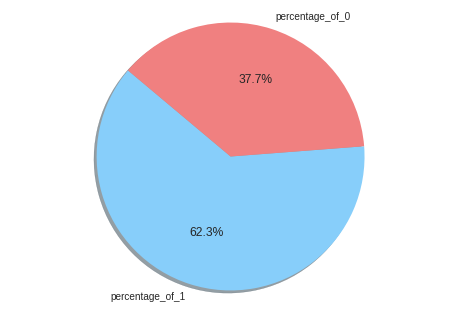

In [0]:
labels = distribution_training.keys()
colors = ['lightskyblue', 'lightcoral']

sizes = [distribution_training[distribution_training.keys()[0]], distribution_training[distribution_training.keys()[1]]]

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

Great! We can see that 62% of training examples are label 1. This is a good to see as our data is not highly skewed in one direction! In the next block of code we check the distribution for our validation set.

In [0]:
%%bigquery --project $project_id distribution_of_validation


SELECT
  SUM(label)/COUNT(label) AS percentage_of_1,
  1-SUM(label)/COUNT(label) AS percentage_of_2
FROM
(
  SELECT
    CASE
      WHEN COUNTIF(injury_severity = 4) > 1
        then 1
        else 0
    END AS label
  FROM 
    `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
    `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
    `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c 
  WHERE
    a.month_of_crash > 8 
    AND a.month_of_crash < 11
    AND a.consecutive_number = b.consecutive_number
    AND b.consecutive_number = c.consecutive_number
    AND a.consecutive_number IN
    (
      SELECT 
        accident.consecutive_number
      FROM 
        `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
      WHERE
        person.consecutive_number = accident.consecutive_number
      GROUP BY 
        accident.consecutive_number
      HAVING COUNT(DISTINCT person.person_number) <> 1
    )
  GROUP BY
    a.consecutive_number
)

,percentage_of_1,percentage_of_2
0,0.621872,0.378128


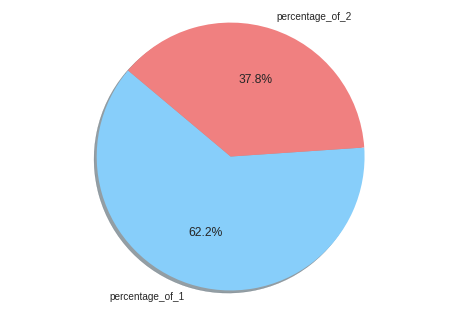

In [0]:
labels = distribution_of_validation.keys()
colors = ['lightskyblue', 'lightcoral']
sizes = [distribution_of_validation[distribution_of_validation.keys()[0]], distribution_of_validation[distribution_of_validation.keys()[1]]]

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

The distribution matches that of the training set, which makes sense. 

In [0]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `extra_fatality.fatality_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c 
WHERE
  a.month_of_crash > 0 
  AND a.month_of_crash < 9
  AND a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash


In [0]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `extra_fatality.fatality_model`)

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,5,0.552966,0.547803,2883,6.4
1,0,4,0.556309,0.552005,3234,3.2
2,0,3,0.581791,0.579016,2840,1.6
3,0,2,0.622380,0.620871,3561,0.8
4,0,1,0.657408,0.656708,3973,0.4
5,0,0,0.680192,0.679949,4491,0.2


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `extra_fatality.fatality_model`, (
SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c 
WHERE
  a.month_of_crash > 8
  AND a.month_of_crash < 11
  AND a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash
),
STRUCT(0.23 AS threshold))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.25428,0.679688,0.478228,0.3701,0.529079,0.571225


As stated above we decided to threshold the binary prediction for label 1 at 0.23 in order to improve our f1_score. 

Let's see the distribution of predictions. 

In [0]:
%%bigquery --project $project_id inference_validation_distribution

SELECT
  SUM(label)/COUNT(label) AS percentage_of_1,
  1 - SUM(label)/COUNT(label) AS percentage_of_0
FROM
  ML.PREDICT(MODEL `extra_fatality.fatality_model`, (
SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c 
WHERE
  a.month_of_crash > 8
  AND a.month_of_crash < 11
  AND a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash
),
STRUCT(0.23 AS threshold))

,percentage_of_1,percentage_of_0
0,0.225522,0.774478


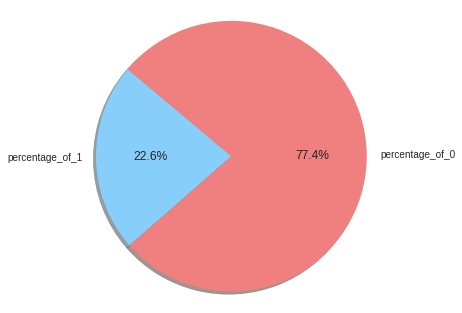

In [0]:
labels = inference_validation_distribution.keys()
colors = ['lightskyblue', 'lightcoral']
sizes = [inference_validation_distribution[inference_validation_distribution.keys()[0]], inference_validation_distribution[inference_validation_distribution.keys()[1]]]

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

We can see that our model predicts label 1, 22% of the time on our validation set. We know that our model is working as it is not predicting the same label for every example. However, our model could do better. Let us try to add in some features with feature engineering!

In [0]:
%%bigquery --project $project_id speed_bucket

SELECT 
  CASE WHEN avg_diff_speed > 0 AND avg_diff_speed < 20 THEN '0-20'
      WHEN avg_diff_speed > 20 AND avg_diff_speed < 40 THEN '20-40'
      WHEN avg_diff_speed > 40 AND avg_diff_speed < 60 THEN '40-60'
      WHEN avg_diff_speed > 60 AND avg_diff_speed < 80 THEN '60-80'
      ELSE '80-'
  END AS speed_group,
  AVG(number_of_fatalities) AS average_fatality
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  (
    SELECT 
      consecutive_number, 
      AVG(ABS(travel_speed-speed_limit)) avg_diff_speed
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` 
    #travel_speed bounded because codes: 997 = speed greater than 96, 998 = speed greater than 151, 999 = unknown
    #Speed_limit bounded because codes: 98= not reported 99= unknown
    WHERE 
      travel_speed <= 151 AND speed_limit <= 80
    GROUP BY 
      consecutive_number
  ) b
WHERE 
  a.consecutive_number = b.consecutive_number
GROUP BY
  speed_group



,speed_group,average_fatality
0,80-,1.079540
1,20-40,1.103656
2,0-20,1.086057
3,40-60,1.132222
4,60-80,1.171521


In [0]:
alt.Chart(speed_bucket).mark_bar().encode(
    alt.X('speed_group:N'),
    alt.Y('average_fatality:Q')
)

Chart({
  data:   speed_group  average_fatality
  0         80-          1.079540
  1       20-40          1.103656
  2        0-20          1.086057
  3       40-60          1.132222
  4       60-80          1.171521,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'speed_group:N'
    }),
    y: Y({
      shorthand: 'average_fatality:Q'
    })
  }),
  mark: 'bar'
})

We discretized speed into 5 groups split by 20MPH each. We can see that the speeds between 60-80 are on average the most fatal. Let us incorporate this feature into our model.

Now let us take a look at if the accident occured in a work zone has an affect on the average fatality.

In [0]:
%%bigquery --project $project_id intersection

SELECT 
  CASE
    WHEN work_zone = "None" THEN 0
    ELSE 1
  END AS is_work_zone,
  AVG(number_of_fatalities)
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` 
GROUP BY
  is_work_zone

,is_work_zone,f0_
0,0,1.087020
1,1,1.136827


We can see that if an accident occurs in a work zone then the average number of fatalities increases. Let us add these two features we have engineered into our model and retrain.

## Model V2 with engineered-features


In [0]:
%%bigquery --project $project_id 

SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5,
  CASE
    WHEN a.work_zone = "None" THEN 0
    ELSE 1
  END AS feature6,
  CASE WHEN avg_diff_speed > 0 AND avg_diff_speed < 20 THEN 0
      WHEN avg_diff_speed > 20 AND avg_diff_speed < 40 THEN 1
      WHEN avg_diff_speed > 40 AND avg_diff_speed < 60 THEN 2
      WHEN avg_diff_speed > 60 AND avg_diff_speed < 80 THEN 3
      ELSE 4
  END AS feature7
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c,
  (
    SELECT 
      consecutive_number, 
      AVG(ABS(travel_speed-speed_limit)) avg_diff_speed
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` 
    #travel_speed bounded because codes: 997 = speed greater than 96, 998 = speed greater than 151, 999 = unknown
    #Speed_limit bounded because codes: 98= not reported 99= unknown
    WHERE 
      travel_speed <= 151 AND speed_limit <= 80
    GROUP BY 
      consecutive_number
  ) d
WHERE
  a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND c.consecutive_number = d.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash, a.work_zone, avg_diff_speed


,label,feature1,feature2,feature3,feature4,feature5,feature6,feature7
0,0,1,4,1,6,0,0,4
1,0,1,31,1,6,0,0,4
2,0,1,4,1,6,0,0,4
3,0,1,15,1,6,0,0,0
4,1,1,2,1,5,0,0,1
5,0,1,66,1,6,0,0,0
6,1,1,2,1,1,0,0,4
7,1,1,4,1,1,0,0,4
8,1,1,40,2,1,1,0,1
9,0,1,31,1,1,1,0,1


In [0]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `extra_fatality.fatality_model_v2`
OPTIONS(model_type='logistic_reg') AS
SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5,
  CASE
    WHEN a.work_zone = "None" THEN 0
    ELSE 1
  END AS feature6,
  CASE WHEN avg_diff_speed > 0 AND avg_diff_speed < 20 THEN 0
      WHEN avg_diff_speed > 20 AND avg_diff_speed < 40 THEN 1
      WHEN avg_diff_speed > 40 AND avg_diff_speed < 60 THEN 2
      WHEN avg_diff_speed > 60 AND avg_diff_speed < 80 THEN 3
      ELSE 4
  END AS feature7
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c,
  (
    SELECT 
      consecutive_number, 
      AVG(ABS(travel_speed-speed_limit)) avg_diff_speed
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` 
    #travel_speed bounded because codes: 997 = speed greater than 96, 998 = speed greater than 151, 999 = unknown
    #Speed_limit bounded because codes: 98= not reported 99= unknown
    WHERE 
      travel_speed <= 151 AND speed_limit <= 80
    GROUP BY 
      consecutive_number
  ) d
WHERE
  a.month_of_crash > 0
  AND a.month_of_crash < 9
  AND a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND c.consecutive_number = d.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash, a.work_zone, avg_diff_speed


Executing query with job ID: 8e8967df-a7a3-4743-966e-be19689891fe
Query executing: 41.45s

ValueError: ignored

In [0]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `extra_fatality.fatality_model_v2`)

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,5,0.559810,0.557844,2778,6.4
1,0,4,0.562960,0.561458,3033,3.2
2,0,3,0.587157,0.585846,3317,1.6
3,0,2,0.625787,0.624886,2827,0.8
4,0,1,0.659130,0.658655,2824,0.4
5,0,0,0.680817,0.680641,2434,0.2


In [0]:
%%bigquery --project $project_id


SELECT
  *
FROM
  ML.EVALUATE(MODEL `extra_fatality.fatality_model_v2`, (

SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5,
  CASE
    WHEN a.work_zone = "None" THEN 0
    ELSE 1
  END AS feature6,
  CASE WHEN avg_diff_speed > 0 AND avg_diff_speed < 20 THEN 0
      WHEN avg_diff_speed > 20 AND avg_diff_speed < 40 THEN 1
      WHEN avg_diff_speed > 40 AND avg_diff_speed < 60 THEN 2
      WHEN avg_diff_speed > 60 AND avg_diff_speed < 80 THEN 3
      ELSE 4
  END AS feature7
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c,
  (
    SELECT 
      consecutive_number, 
      AVG(ABS(travel_speed-speed_limit)) avg_diff_speed
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` 
    #travel_speed bounded because codes: 997 = speed greater than 96, 998 = speed greater than 151, 999 = unknown
    #Speed_limit bounded because codes: 98= not reported 99= unknown
    WHERE 
      travel_speed <= 151 AND speed_limit <= 80
    GROUP BY 
      consecutive_number
  ) d
WHERE
  a.month_of_crash > 8
  AND a.month_of_crash < 11
  AND a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND c.consecutive_number = d.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash, a.work_zone, avg_diff_speed
),
STRUCT(0.23 AS threshold))


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.254008,0.74321,0.438955,0.378616,0.532966,0.584524


By comparing f1_scores, we can see that the features that we engineered improved upon our base model! Our base model achieved a f1_score of 0.3701 where as the second version of our model achieved a f1_score of 0.378616. 

Now let us evaluate on the test set!

In [0]:
%%bigquery --project $project_id


SELECT
  *
FROM
  ML.EVALUATE(MODEL `extra_fatality.fatality_model_v2`, (

SELECT
  CASE
    WHEN COUNTIF(injury_severity = 4) > 1
      then 1
      else 0
  END AS label,
  a.state_number AS feature1,
  c.body_type AS feature2,
  a.number_of_drunk_drivers AS feature3,
  a.day_of_week AS feature4,
  a.hour_of_crash AS feature5,
  CASE
    WHEN a.work_zone = "None" THEN 0
    ELSE 1
  END AS feature6,
  CASE WHEN avg_diff_speed > 0 AND avg_diff_speed < 20 THEN 0
      WHEN avg_diff_speed > 20 AND avg_diff_speed < 40 THEN 1
      WHEN avg_diff_speed > 40 AND avg_diff_speed < 60 THEN 2
      WHEN avg_diff_speed > 60 AND avg_diff_speed < 80 THEN 3
      ELSE 4
  END AS feature7
FROM 
  `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` a,
  `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` b,
  `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` c,
  (
    SELECT 
      consecutive_number, 
      AVG(ABS(travel_speed-speed_limit)) avg_diff_speed
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.vehicle_2016` 
    #travel_speed bounded because codes: 997 = speed greater than 96, 998 = speed greater than 151, 999 = unknown
    #Speed_limit bounded because codes: 98= not reported 99= unknown
    WHERE 
      travel_speed <= 151 AND speed_limit <= 80
    GROUP BY 
      consecutive_number
  ) d
WHERE
  a.month_of_crash > 10
  AND a.month_of_crash < 13
  AND a.consecutive_number = b.consecutive_number
  AND b.consecutive_number = c.consecutive_number
  AND c.consecutive_number = d.consecutive_number
  AND a.consecutive_number IN
  (
    SELECT 
      accident.consecutive_number
    FROM 
      `bigquery-public-data.nhtsa_traffic_fatalities.person_2016` person, `bigquery-public-data.nhtsa_traffic_fatalities.accident_2016` accident
    WHERE
      person.consecutive_number = accident.consecutive_number
    GROUP BY 
      accident.consecutive_number
    HAVING COUNT(DISTINCT person.person_number) <> 1
  )
GROUP BY
  a.consecutive_number, a.state_number, c.body_type, a.number_of_drunk_drivers, a.day_of_week, a.hour_of_crash, a.work_zone, avg_diff_speed
),
STRUCT(0.23 AS thresholdA))


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.246209,0.768802,0.420724,0.372973,0.52606,0.577074


# Part 4 | Conclusion

What have you learned? What conclusions have you made or been unable to make about your dataset and why? What is obvious, and what did you not expect to see? Support your statements with the charts or predictions you generated. If you had more time, what other data exploration would you pursue? 

In this project we explored the bigquery-public-data.nhtsa_traffic_fatalities dataset specifically looking at the relationship between certain features and fatalities. 

Right off the bat we did a simple query to count the number of fatalities per state, we saw that California and Texas had the most fatalities (Fig. 1). However, we realized that this may be due to the fact that California and Texas both have very high populations. In order to remedy this, we then normalized the number of fatalities by the population in each state in the next query. In this query we can see that now California and Texas on average do not have the highest number of fatalities! Instead, states like South Carolina and Alabama had higher rates(Fig. 2). We did a similar process for number of drunk drivers and saw similar trends, such as northeast having low numbers of drunk drivers and number of fatalities, while midwest seems higher (Fig. 3 & 4). However, the maps did not exactly match so number of drunk drivers does not guarantee similarly colored average number of fatalities. From this, we found that the state in which the crash occurred would be a good predictor for testing whether there are more than one fatality. 

Next, since we were interested in seeing what factors would influence the likeliness of crashes occurring with more than one fatality, we decided to see which factors influenced average number of fatalities, since higher average fatalities would imply increased number of crashes with more than 1 fatality. Starting with the number of drunk drivers, we found that increased number of drunk drivers showed a trend of increasing the average number of fatalities (Fig. 5). This was in line with what we hypothesized initially because drunk drivers may engage in riskier behavior, leading to increased average number of fatalities per crash, so the result is not very surprising. Next, we investigated the effect of day of the week of crash (Fig. 6). We found that weekends generally had a higher average number of fatalities. Interestingly, the shape of the graph also closely matched the one when we graphed average number of drunk as a function of day of the week of crash. This indicated that the day of the week when the crash occurs could be a good predictor for whether a crash occurs with more than 1 fatality. As you can see in Fig. 7, we then investigated hour of day and noticed…. In relation to the graph on number of drunk drivers. 

We then investigated if body type was a influencing factor on average number of fatalities and found that if a bus body_type was involved, the average number of fatalities was significantly greater than other body types (Fig. 8). This makes sense since buses generally have larger amounts of passengers than other vehicle types. Interestingly, the car body type with the highest average number of fatalities is 3-door/2-door hatchbacks. Interestingly, convertibles have lower average number of fatalities than 2-door hatchbacks, 2-door coupes and 4-door sedans. This is very interesting because society usually perceives convertibles as more dangerous since they do not have a hardtop. Perhaps there were not enough samples since there’s only 341 convertible crash incidents compared to 13216 samples for 4-door sedans.

We looked into whether the age of the driver influenced the average number of fatalities (Fig. 9). There was no noticeable trend for younger or older ages leading to increased average number of fatalities. However, in the case of a 12-year old driver, there’s a significant increase in average number of fatalities. This may also be due to a low sample size of crashes involving a 12-year old driver. Thus, we determined age would not be a good predictor for crash fatalities.

Finally, we wanted to get a better sense of the data prior to building our machine learning model (Fig. 10). We graphed the distributions for number of accidents per number of fatalities. We noticed that most accidents only involved 1 fatality. However, from looking at injury severity, we see that there are a large number of people involved in crashes that are not fatally injured (do not become a fatality). Then we looked at the number of people involved in accidents, we saw that the majority of accidents involved only 1 person. However, 13808 accidents involved more than 1 person, which is enough samples to work with since we decided to investigate, excluding the instances where there’s only one person involved in the crash (guaranteed fatality), whether or not there’s another person involved in the crash that is a fatality?

If we had more time we would have loved to have a dataset of accidents in where there were no fatalities. We were limited by this dataset because each accident had at least 1 fatality. If we had access to data of all accidents we could better analyze the specific features that directly affect the probability of an occupant in a car being fatally injured. Another piece of data that would have been extremely helpful is the total number of trips per car/body type. This data would allow us to normalize accidents for each body type of vehicle to get a better sense of the probability of getting into a fatal accident in the vehicle. 

Furthermore, we would have loved to explore data over multiple years. Crash data for just the United States for just one year is not enough data to train a sophisticated prediction model. If we had more time and more data we would have loved to train a simple multilayer neural network that has more predictive power than a binary logistical regression model.